# Cross validation

We introduce here resampling and cross-validation for predictive models in R. A random cross-validation approach is used.

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read the data

Data from [Spatiotemporally explicit model averaging for forecasting of Alaskan groundfish catch](https://onlinelibrary.wiley.com/doi/10.1002/ece3.4488) (data repo [here](https://zenodo.org/record/4987796#.ZHcLL9JBxhE))

It's data on fish catch (multiple fish species) over time in different regions of Alaska.

In [169]:
url= "https://zenodo.org/records/4987796/files/stema_data.csv"
fish = pd.read_csv(url)
fish.head()

,Unnamed: 0,Station,Year,Area,Species,Latitude,Longitude,CPUE,SST_cvW,SST_cvW5,SST_cvW4,SST_cvW3,SST_cvW2,SST_cvW1
0,2092,62,1990,Western Gulf of Alaska,Pacific cod,52.663,-168.988,1.212,0.222324,0.252917,0.209706,0.187889,0.195080,0.296625
1,2093,62,1991,Western Gulf of Alaska,Pacific cod,52.663,-168.988,0.645,0.236036,0.209706,0.187889,0.195080,0.296625,0.222324
2,2094,62,1992,Western Gulf of Alaska,Pacific cod,52.663,-168.988,2.661,0.252917,0.187889,0.195080,0.296625,0.222324,0.236036
3,2095,62,1993,Western Gulf of Alaska,Pacific cod,52.663,-168.988,1.947,0.209706,0.195080,0.296625,0.222324,0.236036,0.252917
4,2096,62,1994,Western Gulf of Alaska,Pacific cod,52.663,-168.988,1.767,0.187889,0.296625,0.222324,0.236036,0.252917,0.209706


-   **CPUE**: target variable, "catch per unit effort"
-   **SST**: sea surface temperature
-   **CV**: actually, the coefficient of variation for SST is used $\rightarrow$ the coefficient of variation is an improved measure of seasonal SST over the mean, because it standardizes scale and allows us to consider the changes in variation of SST with the changes in mean over (Hannah Correia, 2018 - Ecology and Evolution)
-   **SSTcvW1-5**: CPUE is influenced by survival in the first year of life. Water temperature affects survival, and juvenile fish are more susceptible to environmental changes than adults. Therefore, CPUE for a given year is likely linked to the winter SST at the juvenile state. Since this survey targets waters during the summer and the four species covered reach maturity at 5--8 years, SST was lagged for years one through five to allow us to capture the effect of SST on the juvenile stages. All five lagged SST measures were included for modeling.

### Data preprocessing

-   `V1` is record ID
-   `Station` indicates the fishing station

We will not consider these variables in the predictive model: remove here, or use `tidymodels` `roles`?

In order to accommodate variation in SST among stations, the CPUE value has been replicated multiple times. This would defeat our purpose of analysing data by group (fish species) over space and time: with only one value per group, a statistical analysis is a bit hard to be performed (no variation). Therefore, to the original CPUE values we add some random noise proportional to the average (by species, area, year):

In [170]:
fish = fish.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'Station'], axis=1)

In [171]:
## mutate variable
fish['avg'] = fish.groupby(['Species', 'Area', 'Year'])['CPUE'].transform('mean')
fish['std'] = 0.1 * fish['avg']

In [172]:
fish['noise'] = np.random.normal(loc=0, scale=fish['std'])
fish['CPUE'] = fish['CPUE'] + fish['noise']

In [173]:
fish = fish.drop(['avg', 'std', 'noise'], axis=1)

In [174]:
fish.head()

,Year,Area,Species,CPUE,SST_cvW,SST_cvW5,SST_cvW4,SST_cvW3,SST_cvW2,SST_cvW1
0,1990,Western Gulf of Alaska,Pacific cod,1.098413,0.222324,0.252917,0.209706,0.187889,0.195080,0.296625
1,1991,Western Gulf of Alaska,Pacific cod,0.689515,0.236036,0.209706,0.187889,0.195080,0.296625,0.222324
2,1992,Western Gulf of Alaska,Pacific cod,2.822898,0.252917,0.187889,0.195080,0.296625,0.222324,0.236036
3,1993,Western Gulf of Alaska,Pacific cod,1.788830,0.209706,0.195080,0.296625,0.222324,0.236036,0.252917
4,1994,Western Gulf of Alaska,Pacific cod,1.740602,0.187889,0.296625,0.222324,0.236036,0.252917,0.209706


In [175]:
y = np.array(fish['CPUE'])
X = np.array(fish[['Year','SST_cvW', 'SST_cvW5', 'SST_cvW4','SST_cvW3','SST_cvW2','SST_cvW1']])

#### One-hot encoding of categorical variables

In [176]:
categorical_columns = fish.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Area', 'Species']

In [178]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')

In [179]:
X_ohe = ohe.fit_transform(fish[categorical_columns]).toarray()
#one_hot_array = encoder.fit_transform(df[['color']]).toarray()

In [180]:
X_ohe

array([[0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.]])

In [181]:
X_ohe.shape

(6716, 6)

In [182]:
X = np.concatenate((X, X_ohe), axis=1)
X.shape

(6716, 13)

### Cross validation: training/test split

We start with a simple random split: 80% data for training, 10% test data

In [195]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [196]:
X_train.shape

(6044, 13)

In [198]:
X_test.shape

(672, 13)

#### Data normalization

We normalise the data using **standardization**: we want our numerical features to have zero mean and unit variance.

First, we subset the trainig data by taking only the numerical features (first 7 columns). Please note that we are using the **training data for normalization**: this is important, since in real applications you don't have yet the test data.

In [200]:
ncols = X_train.shape[1]
X_temp = X_train[:,0:7] ## the last index in the range is not included

In [205]:
X_train.mean(axis=0)

array([2.00100728e+03, 1.93945903e-01, 1.90615991e-01, 1.93183271e-01,
       1.95524450e-01, 1.92174325e-01, 1.93562533e-01, 2.45367306e-01,
       1.64791529e-01, 1.36995367e-01, 2.50827267e-01, 2.50496360e-01,
       2.47849107e-01])

In [201]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_temp)

In [203]:
X_train_scaled.mean(axis=0) ## all features have now zero mean

array([-1.42968768e-15, -3.04888845e-15, -4.19952329e-15,  9.79362190e-16,
       -4.93023337e-15,  3.23458078e-15,  1.90100895e-16])

In [206]:
X_train_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1.])

In [207]:
X_train_scaled = np.concatenate((X_train_scaled, X_train[:,7:ncols]), axis=1)
X_train_scaled.shape

(6044, 13)

In [208]:
X_temp = X_test[:,0:7]
X_test_scaled = scaler.transform(X_temp)
X_test_scaled = np.concatenate((X_test_scaled, X_test[:,7:ncols]), axis=1)

### Linear regression model

In [209]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_scaled, y_train)

In [210]:
reg.coef_

array([-0.08611974, -0.04919965, -0.11227253,  0.10912014,  0.12921954,
        0.09635828, -0.08552367, -1.68962805, -1.35725172,  0.82696775,
       -5.69958189, -5.46879849,  3.00627159])

In [211]:
print(reg.score(X_train_scaled,y_train))

0.7591908332973867


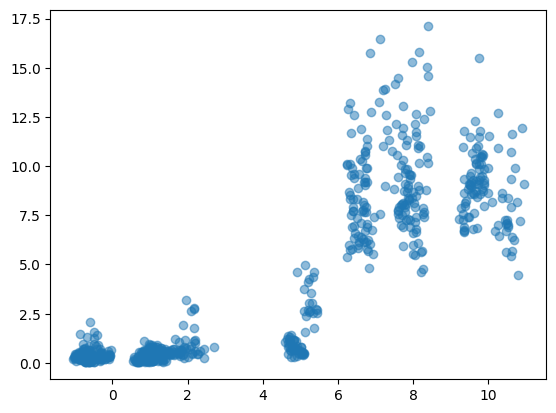

In [212]:
y_hat = reg.predict(X_test_scaled)

plt.scatter(y_hat, y_test, alpha=0.5)
plt.show()

In [213]:
np.corrcoef(y_test,reg.predict(X_test_scaled))

array([[1.        , 0.86194625],
       [0.86194625, 1.        ]])

## k-fold cross validation

!['k-fold-cv'](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [229]:
def train_test_model(feat_train, targ_train, feat_val, targ_val):

  ## data normalization
  scaler = preprocessing.StandardScaler()
  feat_train_scaled = scaler.fit_transform(feat_train)
  feat_val_scaled = scaler.transform(feat_val)

  ## fit linear regression model
  modfit = LinearRegression().fit(feat_train_scaled, targ_train)

  ## model evaluation
  y_hat = modfit.predict(feat_val_scaled)
  pears_corr = np.corrcoef(targ_val, y_hat)[0,1]

  return(pears_corr)

In [237]:
from sklearn.model_selection import KFold

# KFold split
nsplits = 10
kf = KFold(n_splits=nsplits)
res = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")

    ## train and validatino sets
    val_X = X[test_index,:]
    val_y = y[test_index]

    train_X = X[train_index,:]
    train_y = y[train_index]

    print("size of train set:", len(train_y))
    print("size of test set:", len(val_y))

    temp = train_test_model(train_X, train_y, val_X, val_y)
    print(temp)

    res.append(temp)


Fold 0:
size of train set: 6044
size of test set: 672
0.5146258636840927
Fold 1:
size of train set: 6044
size of test set: 672
0.12833725673550808
Fold 2:
size of train set: 6044
size of test set: 672
0.8671182267657002
Fold 3:
size of train set: 6044
size of test set: 672
0.7637020626074965
Fold 4:
size of train set: 6044
size of test set: 672
0.7184959295407131
Fold 5:
size of train set: 6044
size of test set: 672
0.2863098711981286
Fold 6:
size of train set: 6045
size of test set: 671
-0.26446759646871476
Fold 7:
size of train set: 6045
size of test set: 671
0.9226362425611428
Fold 8:
size of train set: 6045
size of test set: 671
0.05472980739598686
Fold 9:
size of train set: 6045
size of test set: 671
0.06746434215229022


In [238]:
np.mean(res)

np.float64(0.4058952006172344)